<a href="https://colab.research.google.com/github/yithung18/Calories-burnt-prediction/blob/main/Calorie_burnt_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

from google.colab import files
uploaded = files.upload()


Saving calories.csv to calories.csv


In [2]:
df = pd.read_csv('calories.csv')
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [3]:
df.shape


(15000, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [5]:
df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


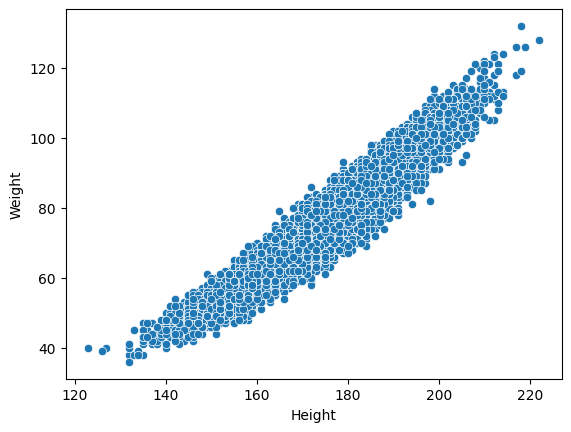

In [6]:
sb.scatterplot(x="Height", y="Weight", data=df)
plt.show()

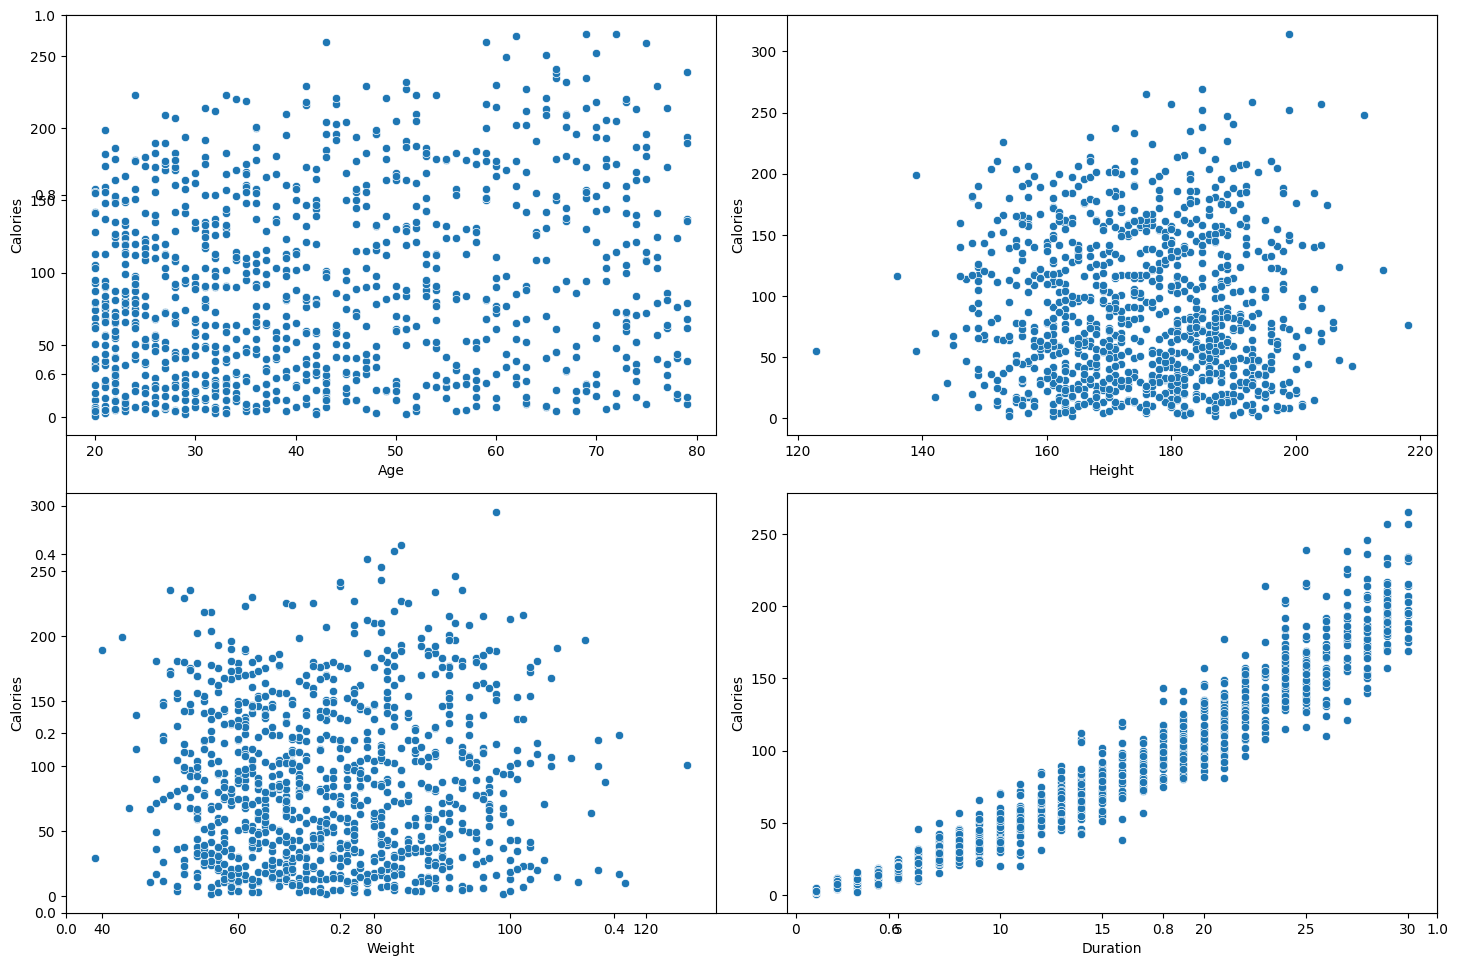

In [7]:
features = ["Age","Height",'Weight','Duration']

plt.subplots(figsize=(15,10))
for i, col in enumerate(features):
  plt.subplot(2, 2, i+1)
  x = df.sample(1000)
  sb.scatterplot(x=col, y='Calories', data=x)
plt.tight_layout()
plt.show()

As the result shown, the higher the duration of workout, the higher the calories burnt.
But we cannot based on the weight or height to determine the calories burnt.

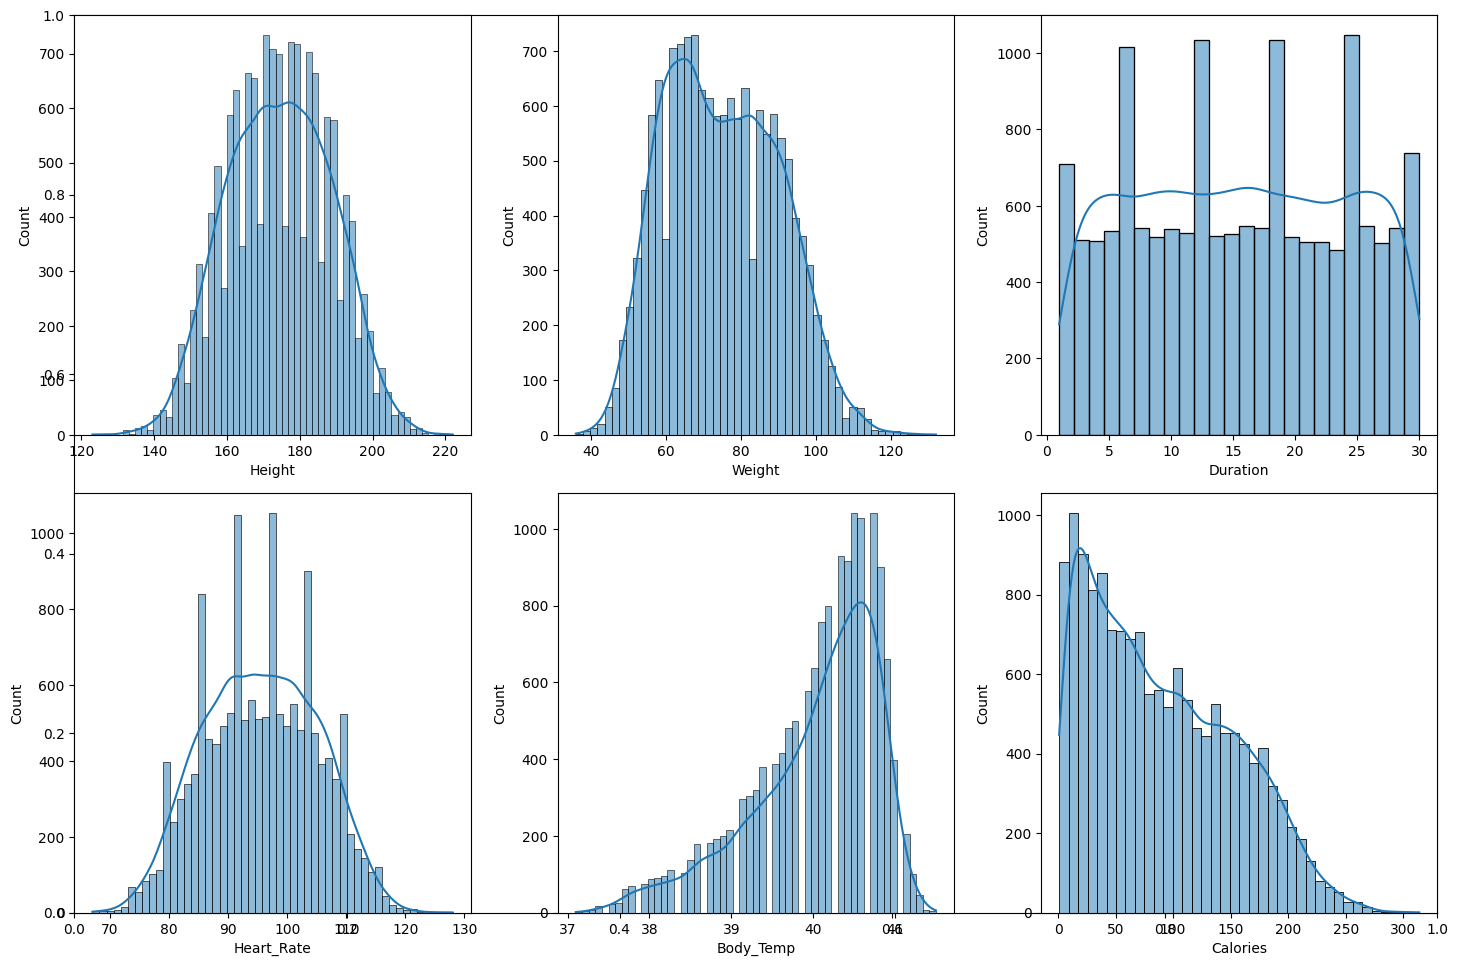

In [8]:
features = df.select_dtypes(include='float').columns

plt.subplots(figsize=(15,10))
for i , col in enumerate(features):
  plt.subplot(2, 3, i+1)
  sb.histplot(df[col], kde=True)
plt.tight_layout()
plt.show()

The distribution of the continuous features follows close to normal distribution except for some features such as, Body_Temp and Calories

In [9]:
df.replace({'male': 0, 'female': 1}, inplace=True)
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,0,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,1,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,0,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,1,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,1,27,154.0,58.0,10.0,81.0,39.8,35.0


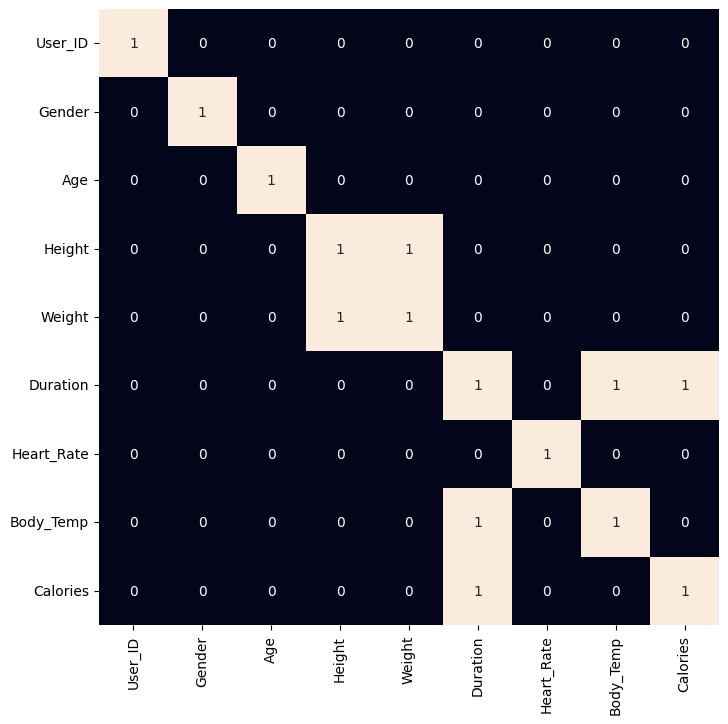

In [10]:
plt.figure(figsize=(8,8))
sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()

Here we have a serious problem of data leakage as there is a feature that is highly correlated eith the target column which is calories.

In [11]:
to_remove = ['Weight', 'Duration']
df.drop(to_remove, axis=1, inplace=True)

**Model Training**

Now we will seperate the features and target variables and split them into training and testing data by using which we will select the model which is performing best on the validation data.

In [12]:
features = df.drop(['User_ID', 'Calories'], axis=1)
target = df['Calories'].values

X_train, X_val,Y_train,Y_val = train_test_split(features, target, test_size=0.1,random_state=22)
X_train.shape, X_val.shape


((13500, 5), (1500, 5))

Now, Normlaize the data to obtain stable and fast training.


In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


Now train some state-of-the-art machine learning models and compare them which fit better with our data.

In [14]:
from sklearn.metrics import mean_squared_error as mae
models = [LinearRegression(), XGBRegressor(), Lasso(), RandomForestRegressor(), Ridge()]

for i in range(5):
  models[i].fit(X_train, Y_train)
  print(f'{models[i]:}: ')

  train_preds = models[i].predict(X_train)
  print('Training Error: ', mae(Y_train, train_preds))

  val_preds = models[i].predict(X_val)
  print('Validation Error: ', mae(Y_val, val_preds))
  print()

LinearRegression(): 
Training Error:  505.991591858055
Validation Error:  520.8238586334786

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...): 
Training Error:  121.1118117279729
Validation Error:  204.19671137981607

Lasso(): 
Training Error:  508.9620753658875
Validation Error:  521.6785974670034

R

Out of the above models, we have trained RandomForestRegrssor and the XGB model's performance is the same as their MAE for the validation data is same.